**1. The first section of the notebook should explain the data: what is included, how it was obtained, and all important details about how it was sampled from the student's own digital archive.**

For this project, I use my own voice messages that I’ve sent to my friends and family over the past few years. I speak both Kazakh and Russian, and I often switch between them depending on who I’m talking to. My international friends sometimes try to guess which language I’m speaking, so I thought it would be fun to see if a computer could do a better job than they do.

To build my dataset, I went through my Telegram and WhatsApp chat histories, and listened to old voice messages. From there, I selected clips where I speak clearly in one language without too much background noise. Because I often mix languages within a message, finding clean, single-language clips was challenging. To respect privacy, I excluded any recordings that contained personal or sensitive information, keeping only everyday conversations, greetings, and casual stories. As a result, the sample size is small but carefully chosen: 20 clips per language.

I ended up with two folders of recordings: one for Kazakh and one for Russian. Each folder has the same number of samples, so the dataset is balanced between the two languages.

Initially, the messages were stored in various formats such as .ogg, .m4a, and .mp4 (depending on whether they were downloaded from Telegram or WhatsApp). I converted all files to .wav using FFmpeg to ensure consistency in file type and sampling rate before feature extraction. All files were renamed with a simple labeling convention (e.g., “kazakh_01.wav”, “russian_01.wav”).

**2. The second section of the notebook should contain well-commented code for converting this data to python readable format (and scikit-learn) and loading this data into an appropriate data structure (np.array, pandas dataframe, glob etc.).**

To process the data, I stored the two language folders in Google Drive and mounted the Drive in Google Colab so the notebook could access the recordings directly.

Each audio file path was collected using the glob library and labeled with its corresponding language.
The resulting structure was stored in a Pandas DataFrame, making it easy to manipulate, analyze, and later use for feature extraction.

The DataFrame contains two columns:

- filepath - the location of the .wav file

- language - the label indicating the spoken language (kazakh or russian)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import all the necessary libraries
import os
import glob
import pandas as pd
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [ ]:
# define the paths to my folders
kazakh_path = "/content/drive/MyDrive/data/kazakh/"
russian_path = "/content/drive/MyDrive/data/russian/"

# collect all file paths
kazakh_files = glob.glob(os.path.join(kazakh_path, "*.wav"))
russian_files = glob.glob(os.path.join(russian_path, "*.wav"))

# create a DataFrame that lists each file and its label
data = []

for file in kazakh_files:
    data.append({"filepath": file, "language": "kazakh"})

for file in russian_files:
    data.append({"filepath": file, "language": "russian"})

df = pd.DataFrame(data)

# preview the dataset structure
print("Total samples:", len(df))
df.head()


Total samples: 40


,filepath,language
0,/content/drive/MyDrive/data/kazakh/kazakh_01.wav,kazakh
1,/content/drive/MyDrive/data/kazakh/kazakh_10.wav,kazakh
2,/content/drive/MyDrive/data/kazakh/kazakh_13.wav,kazakh
3,/content/drive/MyDrive/data/kazakh/kazakh_04.wav,kazakh
4,/content/drive/MyDrive/data/kazakh/kazakh_06.wav,kazakh


**3. The third section of the notebook should include a markdown section explaining any necessary cleaning, pre-processing, and feature engineering the data requires, and include a code block completing these steps. You should also perform some basic exploratory data analysis at this point reporting and visualizing the samples and computing appropriate descriptive statistics.**

The goal of this section is to convert each audio file into a structured numerical representation that captures essential information about how I speak in each language.

**Feature engineering**

Since the raw waveform itself contains thousands of data points per second, I extract summary features that describe the audio’s key characteristics.

Specifically, I compute the following features for each clip:

- Duration - total length of the clip (in seconds)

- Zero-Crossing Rate (ZCR) - how often the waveform changes sign, capturing noisiness and articulation

- Spectral Centroid - where the "center of mass" of the spectrum lies, roughly measuring brightness.

- Root Mean Square (RMS) - an estimate of overall loudness or energy

- MFCCs (Mel-Frequency Cepstral Coefficients) - features that  summarize the phonetic structure of the speech and are widely used in language and speech recognition.

Classical speech recognition systems typically use 13 MFCCs, as these capture the main spectral characteristics relevant to human perception. Extracting more (e.g., 40) can capture finer details, but since my dataset is small (40 total clips), I used 13 coefficients to maintain interpretability and reduce overfitting risk.

After computing these features, I store them in a DataFrame with one row per recording.
I then visualize the distributions of some features to check for outliers, differences between languages, and overall data balance.

In [ ]:
def extract_features(file_path):
    """
    Extracts relevant audio features from a .wav file.
    Returns a dictionary of features.
    """
    y, sr = librosa.load(file_path, sr=16000)  # ensure consistent sample rate

    # compute features
    duration = librosa.get_duration(y=y, sr=sr)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))
    centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    rms = np.mean(librosa.feature.rms(y=y))

    # extract MFCCs (take the mean of each coefficient)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_means = np.mean(mfccs, axis=1)

    features = {
        "duration": duration,
        "zero_crossing_rate": zcr,
        "spectral_centroid": centroid,
        "rms": rms
    }

    # add MFCCs as separate columns
    for i, coeff in enumerate(mfcc_means, start=1):
        features[f"mfcc_{i}"] = coeff

    return features

# apply the function to each file
feature_list = []
for _, row in df.iterrows():
    feats = extract_features(row["filepath"])
    feats["language"] = row["language"]
    feature_list.append(feats)

# convert to DataFrame
df_features = pd.DataFrame(feature_list)

# preview the feature table
print("Feature table shape:", df_features.shape)
df_features.head()

Feature table shape: (40, 18)


,duration,zero_crossing_rate,spectral_centroid,rms,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,language
0,15.2735,0.152678,2121.041741,0.028174,-304.419159,69.975166,10.337480,14.791806,-4.492419,11.484734,-13.172105,-1.663516,-12.376064,5.489880,-11.968811,1.923341,-4.948842,kazakh
1,32.6935,0.168428,2308.842955,0.024044,-304.681213,63.566078,10.590624,10.550840,-0.866393,11.032961,-4.016727,-1.460371,-2.296667,5.880396,-12.207376,-0.235313,-4.148695,kazakh
2,14.4535,0.151086,2145.640777,0.031071,-293.799774,71.854866,12.735107,11.604885,5.293923,9.468462,0.938012,-2.871969,-1.670666,6.892905,-9.275065,0.872208,-5.421408,kazakh
3,17.2135,0.120181,1981.812587,0.027999,-357.487000,80.575966,31.652409,9.579430,6.716884,-1.158661,-3.236280,3.557565,0.644195,2.507810,-5.491188,5.876114,-2.826779,kazakh
4,18.2735,0.148637,2053.123952,0.034406,-328.645477,76.835625,34.327827,19.879921,2.814452,-13.603940,-4.237973,-0.884887,-5.263288,-0.921361,-9.316368,1.713010,-5.063363,kazakh


Because each feature is computed as an average over time, all audio clips are automatically represented as fixed-length feature vectors, regardless of their original duration. Therefore, it is not necessary to truncate, pad, or amplitude-normalize the recordings.

**Exploratory Data Analysis (EDA)**

Summary statistics for numerical features:


,duration,zero_crossing_rate,spectral_centroid,rms,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,22.021542,0.146898,1988.514433,0.041397,-291.488617,81.886086,15.944339,9.348631,0.640995,-1.431347,-7.670372,-3.099746,-5.647680,1.731184,-6.648076,-0.296509,-3.158797
std,14.364920,0.026471,274.177806,0.021634,53.606644,16.563585,11.636055,8.850078,8.818260,10.263638,5.697497,4.187110,5.261387,3.642913,4.549273,3.807405,3.587303
min,4.833500,0.102051,1423.281415,0.012251,-394.547943,55.926147,-16.342873,-19.353817,-29.764324,-26.153177,-20.144665,-14.053824,-21.494146,-6.660004,-14.947844,-9.858103,-10.541959
25%,14.288500,0.127139,1805.512866,0.027922,-319.035667,69.673853,9.079588,7.322319,-4.280291,-8.844450,-12.164931,-6.458838,-8.882021,-1.007470,-10.432733,-2.435764,-5.299097
50%,18.263500,0.144265,2052.931887,0.034257,-299.547287,76.681866,15.405524,10.550291,1.334062,-1.205407,-6.667074,-3.077427,-5.722914,2.226587,-6.678554,0.377366,-3.304575
75%,26.693391,0.167236,2187.877582,0.052636,-272.811127,96.108461,22.478983,14.714102,5.649663,7.321146,-3.762396,-0.601375,-2.140167,4.849102,-2.954080,2.495784,-0.936950
max,73.493500,0.200259,2448.050156,0.122287,-140.855270,119.355156,36.428467,23.081070,14.396093,15.845225,1.491723,4.911591,3.670445,7.592445,3.674605,5.876114,6.218363


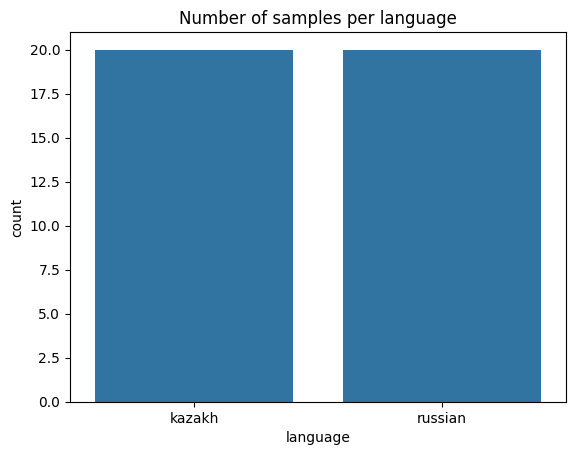

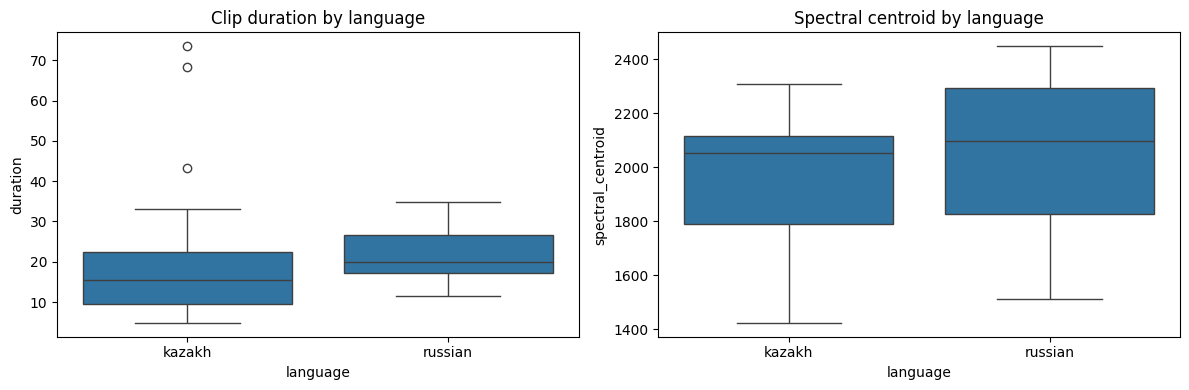

In [ ]:
# summary statistics
print("Summary statistics for numerical features:")
display(df_features.describe())

# check balance between languages
sns.countplot(data=df_features, x="language")
plt.title("Number of samples per language")
plt.ylabel("count")
plt.show()

# compare distributions of duration and spectral centroid
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.boxplot(data=df_features, x="language", y="duration", ax=axes[0])
axes[0].set_title("Clip duration by language")

sns.boxplot(data=df_features, x="language", y="spectral_centroid", ax=axes[1])
axes[1].set_title("Spectral centroid by language")

plt.tight_layout()
plt.show()


The countplot confirms that our dataset is perfectly balanced with 20 samples for each language. The descriptive statistics from .describe() give us a baseline understanding of the range and central tendency for each of our engineered features.

*Duration*

The first boxplot show that the median duration for both languages is roughly similar. However, Kazakh samples show greater variability and a few clear outliers (very long clips), while Russian samples are more tightly clustered. This variation could arise from differences in conversational pace or message type.



*Spectral centroid*

This feature represents the “brightness” or energy concentration in the frequency spectrum. Higher values correspond to a sound with more high-frequency components.

Both languages have overlapping distributions with close median values, which is expected because all recordings are of my voice in relatively similar acoustic conditions. Still, the spread in the data implies there may be subtle spectral differences between languages that MFCC features can capture more effectively.

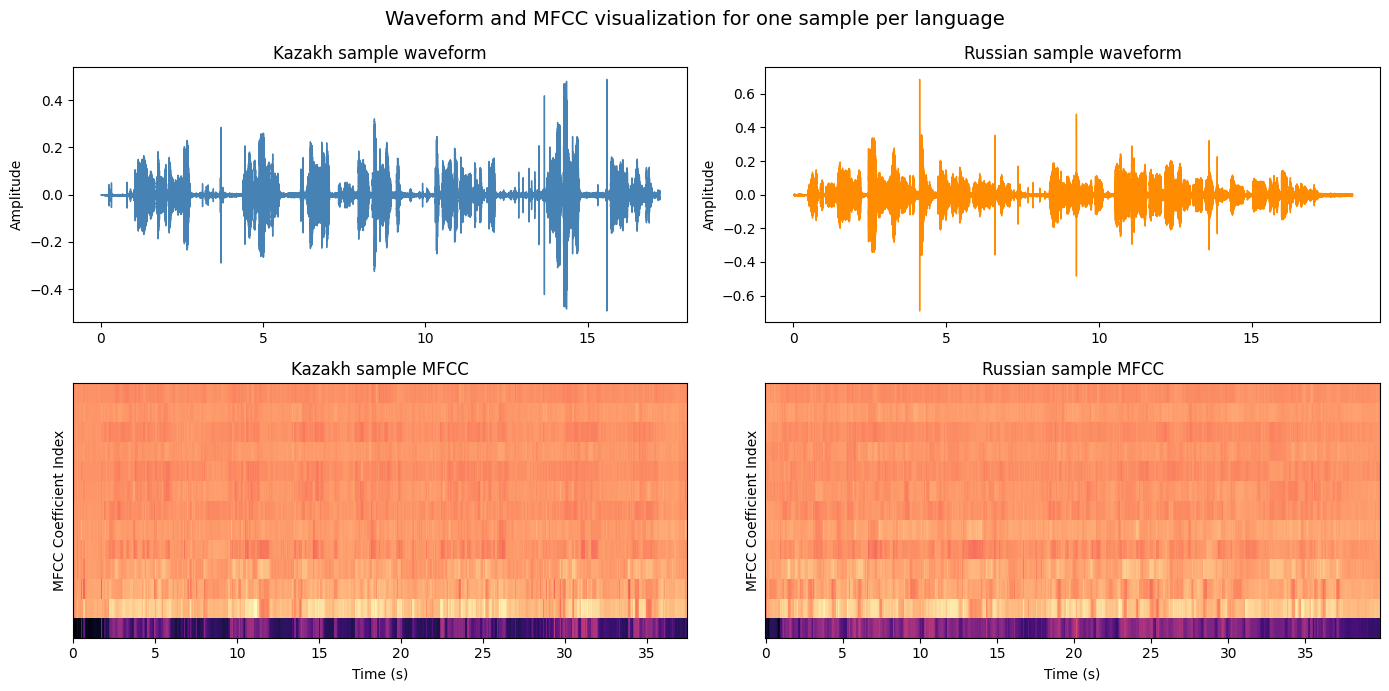

In [ ]:
# randomly pick one sample from each language
random.seed(42) # for reproducibility
kazakh_sample_path = random.choice(df[df['language'] == 'kazakh']['filepath'].tolist())
russian_sample_path = random.choice(df[df['language'] == 'russian']['filepath'].tolist())

# load the audio
y_kazakh, sr_kazakh = librosa.load(kazakh_sample_path, sr=None)
y_russian, sr_russian = librosa.load(russian_sample_path, sr=None)

# compute MFCCs
mfcc_kazakh = librosa.feature.mfcc(y=y_kazakh, sr=sr_kazakh, n_mfcc=13)
mfcc_russian = librosa.feature.mfcc(y=y_russian, sr=sr_russian, n_mfcc=13)


fig, axes = plt.subplots(2, 2, figsize=(14, 7))

# waveforms
librosa.display.waveshow(y_kazakh, sr=sr_kazakh, ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title("Kazakh sample waveform")
axes[0, 0].set_xlabel("")
axes[0, 0].set_ylabel("Amplitude")

librosa.display.waveshow(y_russian, sr=sr_russian, ax=axes[0, 1], color='darkorange')
axes[0, 1].set_title("Russian sample waveform")
axes[0, 1].set_xlabel("")
axes[0, 1].set_ylabel("Amplitude")

# MFCCs
librosa.display.specshow(mfcc_kazakh, x_axis='time', ax=axes[1, 0], cmap='magma')
axes[1, 0].set_title("Kazakh sample MFCC")
axes[1, 0].set_xlabel("Time (s)")
axes[1, 0].set_ylabel("MFCC Coefficient Index")

librosa.display.specshow(mfcc_russian, x_axis='time', ax=axes[1, 1], cmap='magma')
axes[1, 1].set_title("Russian sample MFCC")
axes[1, 1].set_xlabel("Time (s)")
axes[1, 1].set_ylabel("MFCC Coefficient Index")

plt.suptitle("Waveform and MFCC visualization for one sample per language", fontsize=14)
plt.tight_layout()
plt.show()


*Waveform and MFCCs*

The figure compares one Kazakh and one Russian audio sample, showing both the time-domain waveform (top) and the Mel-Frequency Cepstral Coefficients (MFCCs) (bottom) for each.

While the raw waveforms show amplitude variation over time, the MFCC heatmaps visualize the complex "fingerprints" of the audio. There are subtle differences in the distribution and timing of the spectral energy, visible as small shifts in bright horizontal bands. Such patterns are exactly what I hope my machine learning model will be able to detect and learn from in order to distinguish between the two languages.

**4. The fourth section should include a markdown section discussing the analysis (classification, regression, or clustering) that will be conducted on the data, along with well commented code block performs any necessary data splits (such as creating training and test sets)**

Since each sample in the dataset is labeled with a language, the most suitable type of analysis is classification. Specifically, it's a binary classification problem, where:

- Input (X): numerical features extracted from each audio file (duration, ZCR, spectral centroid, RMS, MFCCs)

- Output (y): language label (kazakh = 0, russian = 1)

The objective is to train a model that learns patterns distinguishing Kazakh and Russian speech based on statistical and spectral features such as MFCCs, spectral centroid, and zero-crossing rate.

*Train-test split*

Before training, I split the dataset into training and testing subsets using an 80–20 ratio. The model learns from the training data, and its performance is evaluated on the unseen testing data. Because my dataset is relatively small and perfectly balanced between the two languages, I used stratified sampling. It means that both subsets preserve the same proportion of Kazakh and Russian clips, preventing bias toward one class during training.

*Feature scaling*

Feature scaling is also a crucial preprocessing step, as different features are on very different numerical scales.
To prevent any single feature from dominating the learning process, I standardized all numerical features using the StandardScaler, which transforms each feature to have zero mean and unit variance.
Importantly, the scaler is fitted only on the training data to avoid data leakage. Test data is transformed using the same parameters learned from the training set.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# separate features (X) and target labels (y)
X = df_features.drop(columns=["language"])
y = df_features["language"]

# encode labels numerically
y_encoded = y.map({"kazakh": 0, "russian": 1})

# perform an 80–20 train-test split (stratified to preserve balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

# feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Training samples: 32
Testing samples: 8


**5. The fifth section should discuss model selection in a markdown section and include model initialization and construction in a well-commented code block. This section should include a clear discussion of the model's mathematical underpinnings. This should include typeset equations and/or algorithms as pseudocode.**

For this classification task, I decided to pick something simple and selected logistic regression as the primary model. It is a fundamental and highly interpretable linear classifier that serves as a robust baseline.



*Linear equation*

Logistic Regression models the probability that a given input vector 𝑥 belongs to class 1 (in this case, Russian) rather than class 0 (Kazakh).

The model first computes a weighted sum of the input features, similar to linear regression.  If $X$ is the feature vector and $w$ is the vector of model weights (coefficients), the linear output is:
$$z = w^T X + b$$

$b$ in the formula is the bias term (or intercept), which allows the decision boundary to be shifted.

*Sigmoid function*

Next, it converts this score $z$ into a probability between 0 and 1 by applying  a special function called the sigmoid (logistic) function, denoted by $\sigma(z)$:
$$P(y=1 | X) = \sigma(z) = \frac{1}{1 + e^{-z}}$$

If the output $\sigma(z)$ is greater than a decision threshold (usually 0.5), the sample is classified as class 1. Otherwise, it's classified as class 0.

*Cost function*

The "learning" part of the model is the process of finding the optimal weights ($w$) and bias ($b$) that make the most accurate predictions for the training data, which is achieved by minimizing a cost function. For logistic regression, the cost function is the Binary Cross-Entropy (or Log Loss).

For a single training example, the loss is defined as:

$$\text{Loss}(\hat{y}, y) = -[y \log(\hat{y}) + (1-y) \log(1-\hat{y})]$$
- $y$ is the true label (0 or 1).
- $\hat{y}$ is the model's predicted probability.

This function is designed to heavily penalize the model for predictions that are both confident and wrong. For example, if the true label is $y=1$ but the model predicts a probability of $\hat{y}=0.01$, the loss is very high.

The overall cost function, $L(w, b)$, for the entire training set of $n$ samples is the average of this loss over all samples:

$$L(w, b) = -\frac{1}{n}\sum_{i=1}^{n} [y_{i} \log(\hat{y}_{i}) + (1-y_{i}) \log(1-\hat{y}_{i})]$$

*Gradient descent*

The model uses an optimization algorithm called gradient descent to iteratively adjust the weights $w$ and bias $b$ to find the values that minimize this cost function, resulting in the best possible fit to the training data.

Gradient descent is an iterative algorithm that does this by "walking" downhill from a random starting point. At each step, it determines the direction of the steepest slope and takes a small step in that direction.

The "gradient" is a vector of partial derivatives of the cost function with respect to each weight. The derivative $\frac{\partial L}{\partial w_j}$ tells us the slope of the hill for a specific weight $w_j$.

The algorithm then updates each weight and the bias by taking a small step in the opposite direction of the gradient:
$$w_j := w_j - \alpha \frac{\partial L}{\partial w_j}$$$$b := b - \alpha \frac{\partial L}{\partial b}$$


- $\alpha$ (alpha) is the learning rate, a small hyperparameter (like 0.01) that controls how big of a step to take. Choosing a good learning rate is important. If it's too large, it might overshoot the minimum. If it's too small, it will take too long to converge.

The model repeats this update process many times, until it converges at the minimum of the cost function. At this point, the model has found the optimal parameters to distinguish between kazakh and russian in the training data.


*Regularization*

In practice, logistic regression models often include a regularization term to prevent overfitting, especially when the dataset is small or when some features are correlated. Regularization discourages the model from assigning excessively large weights to any particular feature, which helps the model generalize better to unseen data.

Scikit-learn’s implementation of LogisticRegression applies L2 regularization by default, which adds a penalty term to the cost function proportional to the sum of the squared weights:$$L_{\text{reg}}(w, b) = L(w, b) + \frac{\lambda}{2n} \sum_{j=1}^{m} w_j^2$$

$\lambda$ is the regularization strength that controls how strongly large coefficients are penalized. In the scikit-learn API, this strength is managed by the inverse parameter C:$$C = \frac{1}{\lambda}$$
- A smaller C corresponds to a larger $\lambda$, meaning stronger regularization (a simpler model that is less likely to overfit).
- A larger C corresponds to a smaller $\lambda$, meaning weaker regularization (the model will fit the training data more closely).

In [ ]:
from sklearn.linear_model import LogisticRegression

# initialize the logistic regression model
# C controls regularization strength (smaller C → stronger regularization)
log_reg = LogisticRegression(random_state=42, max_iter=1000, C=1.0)

**6. The sixth section_ _should train the model, including code and explanations for necessary cross validation or hyperparameter tuning.**

Now that the data is prepared and the model is initialized, the next step is to train the model. However, simply fitting the model once on the training data is not enough. The regularization parameter C was initially set to a default value of 1.0, but this might not be the optimal choice for my dataset. Moreover, with a small training set of only 32 samples, the model's performance can be quite sensitive to how the data was split.

To address these issues, I used grid search with k-fold cross-validation, a method to systematically find the best hyperparameter settings and train a more reliable model.

1. I'll create a list of different values for the regularization parameter C.
2. The training data will be split into 5 folds. For each value of C, the model is trained 5 times. In each run, one fold is used for validation, and the other four are used for training.
3. The average accuracy across the 5 folds is calculated.
3. After testing all C values, the grid search will identify the one that achieved the highest average accuracy across all 5 folds.
4. Finally, the model is automatically retrained on the full training set using this best-found C value.

In [ ]:
from sklearn.model_selection import cross_val_score, GridSearchCV

# baseline 5-fold cross-validation on the training data
cv_scores_base = cross_val_score(log_reg, X_train_scaled, y_train, cv=5, scoring="accuracy")
print(f"baseline 5-fold CV accuracy: {cv_scores_base.mean():.3f} ± {cv_scores_base.std():.3f}")

# hyperparameter tuning for regularization strength (C)
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

best_C = grid_search.best_params_["C"]
best_cv_score = grid_search.best_score_
print(f"best C: {best_C}")
print(f"best cross-validation accuracy: {best_cv_score:.3f}")

# refit the model on the full training set with the best C
log_reg_best = LogisticRegression(random_state=42, max_iter=1000, C=best_C)
log_reg_best.fit(X_train_scaled, y_train)

# check CV of the tuned model
cv_scores_best = cross_val_score(log_reg_best, X_train_scaled, y_train, cv=5, scoring="accuracy")
print(f"refit model 5-fold CV accuracy: {cv_scores_best.mean():.3f} ± {cv_scores_best.std():.3f}")


baseline 5-fold CV accuracy: 0.476 ± 0.206
best C: 0.001
best cross-validation accuracy: 0.571
refit model 5-fold CV accuracy: 0.571 ± 0.157


The baseline cross-validation accuracy of 0.476 ± 0.206 indicates that the untuned logistic regression model performed close to random guessing (≈50%), with relatively high variability across folds. The large standard deviation suggests that model performance fluctuated depending on which samples were used for training and validation.

After tuning, the best-performing regularization strength was C = 0.001, which corresponds to strong regularization (since
C is the inverse of the penalty strength λ). Simpler models with smaller weights generalized better across the folds, implying that overfitting might have been a risk when using weaker regularization.

The tuned model achieved a mean cross-validation accuracy of 0.571 ± 0.157, showing a modest but consistent improvement over the baseline.
The reduced variance also suggests that the tuned model is more stable and less dependent on specific data splits.

**7. The seventh section should contain code to generate predictions for out of sample data, and compute appropriate performance metrics.**

The next step is to evaluate tuned model's performance on out-of-sample data (test set). Since this portion of the dataset was never used during training, cross-validation or hyperparameter tuning, it provides an unbiased estimate of how well the model generalizes to unseen speech samples.

I generated predictions for the test set and computed standard classification metrics including:

- accuracy — the overall proportion of correctly classified samples.

- confusion matrix - a visual summary of the prediction results, showing the number of correct predictions (True Positives and True Negatives) and the incorrect ones (False Positives and False Negatives).

- classification report, which includes:
- - precision - of all the clips the model predicted as a certain language, how many were correct?
- - recall - of all the true clips of a certain language, how many did the model correctly identify?
- - f1-score - the harmonic mean of precision and recall, providing a single score that balances both concerns.

Test accuracy: 0.62


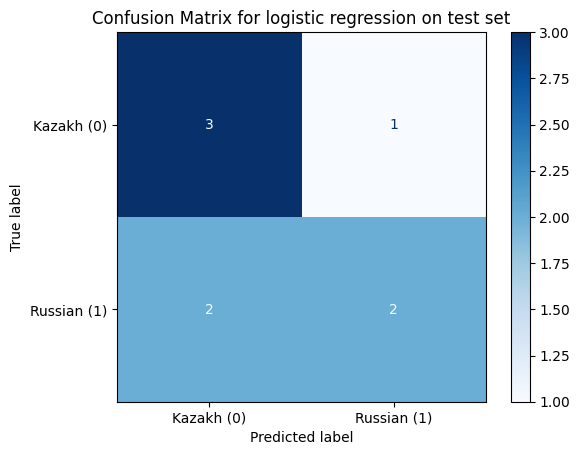

Classification report:
              precision    recall  f1-score   support

      Kazakh       0.60      0.75      0.67         4
     Russian       0.67      0.50      0.57         4

    accuracy                           0.62         8
   macro avg       0.63      0.62      0.62         8
weighted avg       0.63      0.62      0.62         8



In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# generate predictions on the test set
y_pred = log_reg_best.predict(X_test_scaled)

# compute overall accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_accuracy:.2f}")

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Kazakh (0)", "Russian (1)"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for logistic regression on test set")
plt.show()

# detailed classification report
print("Classification report:")
print(classification_report(y_test, y_pred, target_names=["Kazakh", "Russian"]))


**8. The eighth section should visualize the results and discuss your conclusions.**

The final logistic regression model achieved a test accuracy of 0.62, meaning it correctly classified about 62% of the unseen voice clips. Though this is a bit better than a random guess (50%), distinguishing between the two languages based on the engineered features was a genuinely challenging task for this model.

*Confusion matrix analysis*

The confusion matrix shows that:

- out of 4 Kazakh samples, 3 were correctly classified as Kazakh (TN) and 1 was misclassified as Russian (FP).

- out of 4 Russian samples, 2 were correctly identified (TP), while 2 were misclassified as Kazakh (FN).

The model performs slightly better at recognizing Kazakh speech than Russian.

*Classification report analysis*

- Kazakh: The model achieved a recall of 0.75, successfully identifying 75% of all true Kazakh clips, but with a precision of 0.60, meaning that 40% of its “Kazakh” predictions were incorrect.

- Russian: Recall was weaker (0.50), showing that half of the Russian clips were missed. However, its precision (0.67) was slightly higher, indicating better reliability when predicting “Russian.”

*Feature importance analysis*

One advantage of using logistic regression is that it provides interpretable coefficients that directly indicate the relative influence of each feature on the classification decision.
Positive coefficients push the prediction toward the Russian class (labeled 1), while negative coefficients push toward the Kazakh class (0).
The magnitude of the coefficient reflects the strength of that feature’s contribution.

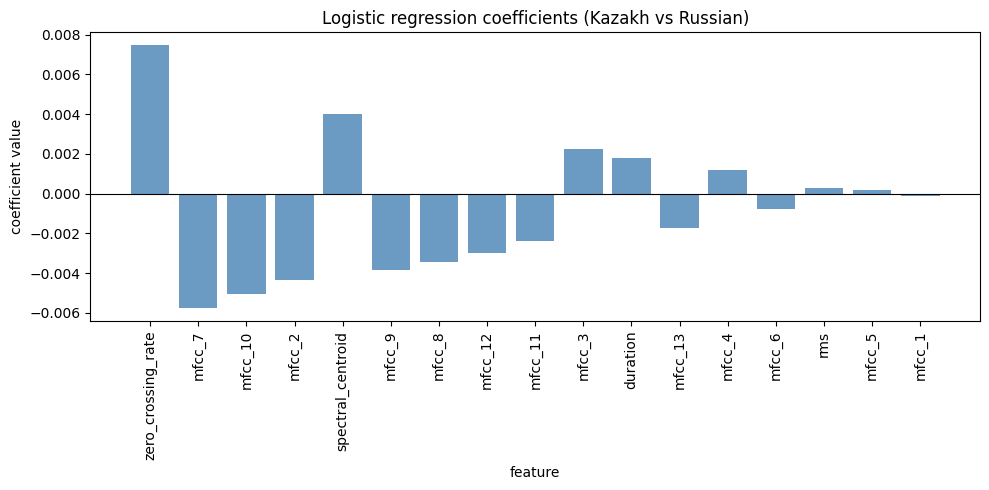

In [ ]:
# retrieve feature names (excluding the label)
feature_names = X.columns

# get coefficients from the trained model
coefficients = log_reg_best.coef_[0]

# sort features by absolute coefficient magnitude
sorted_idx = np.argsort(np.abs(coefficients))[::-1]
sorted_features = feature_names[sorted_idx]
sorted_coeffs = coefficients[sorted_idx]

plt.figure(figsize=(10, 5))
bars = plt.bar(range(len(sorted_coeffs)), sorted_coeffs, color="steelblue", alpha=0.8)
plt.xticks(range(len(sorted_coeffs)), sorted_features, rotation=90)
plt.title("Logistic regression coefficients (Kazakh vs Russian)")
plt.xlabel("feature")
plt.ylabel("coefficient value")
plt.axhline(0, color="black", linewidth=0.8)
plt.tight_layout()
plt.show()


In this case, zero_crossing_rate has the largest positive coefficient, suggesting that higher rates of waveform sign changes are the strongest indicators of Russian speech in my voice. This might potentially reflect sharper consonant boundaries/articulation or more frequent voicing transitions. The spectral_centroid also has a positive coefficient, implying that Russian speech in my recordings tends to be "brighter" with more energy in higher frequencies.

On the other hand, several MFCC coefficients (such as MFCC 7, 10, 2, 9, etc.) have the largest negative weights, indicating that they are the most powerful markers for identifying Kazakh speech. These features capture vowel formant structures and subtle phonetic cues that distinguish Kazakh pronunciation patterns.

Duration and RMS energy have relatively small effects, confirming that the length and overall loudness of my recordings were not significant factors in distinguishing the languages.

*Conclusions*

The project demonstrated that a tuned logistic regression model captures some systematic acoustic differences between Kazakh and Russian but still confuses them frequently. The model's performance is consistent with expectations, given the primary limitations:

- Both datasets contain speech from the same speaker (no speaker variation).

- The total dataset is small (only 40 clips), which restricts the model's ability to generalize.

- The model is linear, so it cannot easily capture more complex nonlinear patterns in the MFCC space.

**9. The ninth section should be an executive summary of the prior eight sections, clearly explaining your steps, diagramming your pipeline, visualizing any key results, and explaining any key insights or shortcomings of your approach. You may wish to include a discussion of how the model might be improved.**

This project explored whether machine learning can distinguish between my Kazakh and Russian voice messages based on acoustic features extracted from short audio clips. The end-to-end machine learning pipeline for this project involved several key stages, as illustrated in the diagram below. The process began with raw audio files and concluded with a comprehensive performance evaluation of the model.

*Pipeline diagram*

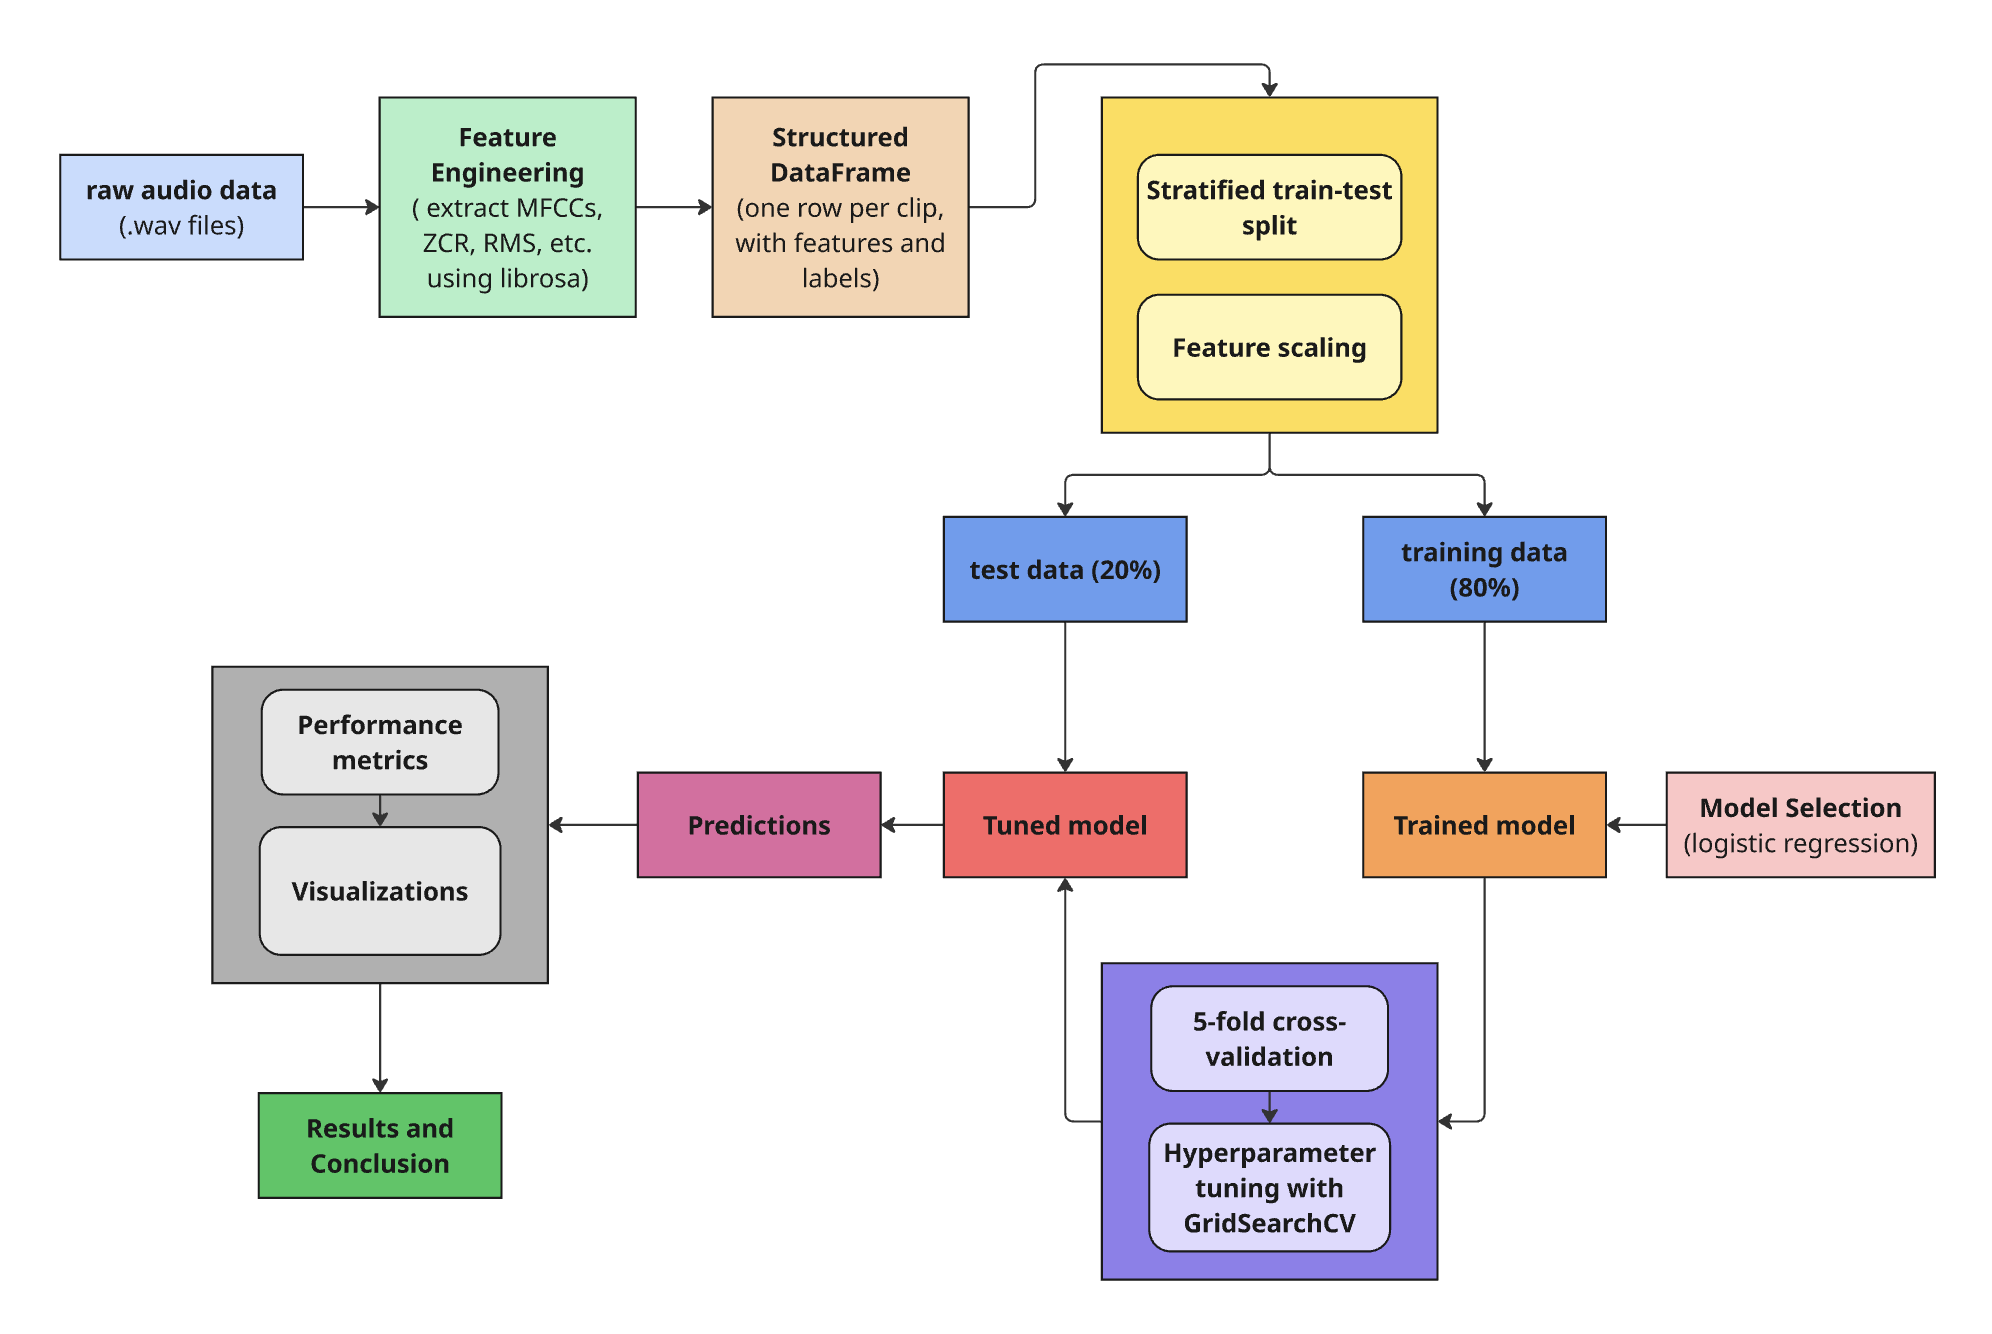

*Pipeline overview*

1. I built a balanced dataset of 40 .wav files (20 Kazakh, 20 Russian) collected from personal Telegram and WhatsApp voice messages. All files were converted to .wav format and standardized to a consistent sampling rate using FFmpeg.
2. Using librosa, I engineered interpretable acoustic features for each clip: duration, zero-crossing rate (ZCR), spectral centroid, root mean square (RMS) energy, and 13 Mel-Frequency Cepstral Coefficients (MFCCs). The extracted features were stored in a Pandas DataFrame, where each row represented one recording.
3. I used a stratified 80–20 train-test split to preserve the class balance between Kazakh and Russian samples. All numerical features were standardized with StandardScaler.
4. A logistic regression classifier was chosen as the main model due to its interpretability and suitability for small datasets. I performed 5-fold cross-validation with grid search over different regularization strengths (C values). The best-performing configuration used C = 0.001, corresponding to stronger regularization that reduced overfitting and stabilized cross-validation scores.
5. The tuned model achieved a cross-validation accuracy of 0.571 ± 0.157 and a test accuracy of 0.62.
The confusion matrix revealed that the model correctly identified most Kazakh clips but occasionally confused Russian ones, reflecting asymmetry in recall and precision.
6. Feature importance analysis revealed that the model learned to rely on complex spectral features (zero_crossing_rate and specific MFCCs), meaning it successfully captured some of the underlying phonetic differences between the two languages.

*Experiment with feature dimensionality (n_mfcc=40)*

As an additional experiment, I explored whether using a richer feature representation would improve classification performance. In the original model, I extracted 13 MFCC coefficients per clip, following the classical convention in speech recognition. However, since higher-dimensional MFCCs can capture more detailed spectral nuances, I repeated the entire pipeline with 40 coefficients while keeping the same model and data splits. The experiment and the results can be found [here.](https://colab.research.google.com/drive/1f3IYWnXKP50wqVCQiWrp_cqTtFqiMrsQ?usp=sharing)

The model trained with 40 MFCCs achieved a much higher mean cross-validated accuracy of 75.7% during tuning. However, its performance on the final, held-back test set was significantly worse, dropping to an accuracy of 50%. While it predicted all the Kazakh samples correctly, it misclassified all Russian samples as Kazakh.

A model has severely overfit to the training data, so my initial hypothesis, outlined in Section 3, was confirmed. While the higher-dimensional features allowed it to achieve a better score during cross-validation, it learned patterns so specific to the 32 training samples that it failed to generalize to the unseen test data.

*Shortcomings and future work*

One shortcoming of this project is the small dataset size (40 clips), which limits the model's ability to learn generalizable patterns. A second, more subtle limitation is the feature engineering approach itself. By taking the mean of the MFCCs, we capture the overall spectral "average" of a clip but lose the crucial time-series information like the rhythm, cadence, and evolution of the sound over time.

Therefore, as an extension, instead of aggregating features, non-linear classifiers like a Recurrent Neural Network (RNN) or a Convolutional Neural Network (CNN) could be trained on the full sequence of MFCCs. In this case, the model will learn the temporal patterns of speech, which are likely key to distinguishing the unique prosody and flow of Kazakh versus Russian. In future work,  if i decide to use richer feature representation (n_mfcc = 40), then I should:
- expand the dataset by including more voice clips, ideally from multiple speakers to capture richer acoustic diversity.
- potentially test both L1 and L2 regularization penalties to more effectively control the overfitting.

**10. The tenth section should contain references for documents, guides, or code repos you accessed for the project.**

*References*

Aristorenas, A. J. (2024, October 31). Machine learning framework for audio-based content evaluation using MFCC, chroma, spectral contrast and temporal feature engineering. https://arxiv.org/abs/2411.00195

FFmpeg Developers. (2024). FFmpeg documentation. FFmpeg. https://ffmpeg.org/documentation.html

Hastie, T., Tibshirani, R., & Friedman, J. (2009). The Elements of Statistical Learning. Chapter 4. Springer. https://www.sas.upenn.edu/~fdiebold/NoHesitations/BookAdvanced.pdf

Librosa Development Team. (2024). Librosa: Audio and music signal analysis in Python (Version 0.10). https://librosa.org/doc/latest/index.html

Logan, B. (2000). Mel frequency cepstral coefficients for music modeling. https://ismir2000.ismir.net/papers/logan_paper.pdf

Molnar, C. (2019). Interpretable Machine Learning. A Guide for Making
Black Box Models Explainable. https://originalstatic.aminer.cn/misc/pdf/Molnar-interpretable-machine-learning_compressed.pdf

Ng, A. (n.d.). CS229 Lecture Notes: Logistic Regression. Stanford University. https://cs229.stanford.edu/main_notes.pdf

Payong, A., & Mukherjee, S. (2025, March 20). Mastering logistic regression with Scikit-Learn: A complete guide. DigitalOcean Community. https://www.digitalocean.com/community/tutorials/logistic-regression-with-scikit-learn

Scikit-learn User Guide. (n.d.). 3.1. Cross-validation: evaluating estimator performance. Retrieved from https://scikit-learn.org/stable/modules/cross_validation.html

Scikit-learn User Guide. (n.d.). 6.3. Preprocessing data. Retrieved from https://scikit-learn.org/stable/modules/preprocessing.html

